In [ ]:
from google.colab import drive

drive.mount('/content/drive')

In [ ]:
!pip install traces

In [ ]:
## Bibliotecas
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import traces
import warnings
warnings.filterwarnings('ignore')

# Extraindo os dados relevantes e Consolidando datas

In [ ]:
PATH = "/content/drive/MyDrive/tabela_ofertas_caneta.csv"
DATE_COLUMN = "timestamp_evento"

data = pd.read_csv(PATH)

data[DATE_COLUMN] = pd.to_datetime(data[DATE_COLUMN])

In [ ]:
TARGET = 'preco_da_oferta'
FEATURES = ['id_item_pai','id_seller']
data['date'] = pd.DatetimeIndex(data[DATE_COLUMN]).normalize()

data = data[['date', TARGET] + FEATURES]

In [ ]:
data = data.fillna(method="ffill")

In [ ]:
data.to_csv("/content/drive/MyDrive/tabela_ofertas_caneta_data_ajustada.csv",index=False,encoding="utf-8")

In [ ]:
data.head()

,date,preco_da_oferta,id_item_pai,id_seller
0,2021-06-01 00:00:00+00:00,27.0,TYIo9zZLIGhYaa7oI5xGnBcCDmQJatRXeydWVdHC6b4=,Cf1BN5s/Z5cNsOvSUmEHGrqOPMkivBAktP2bXAJ+YdY=
1,2021-06-01 00:00:00+00:00,27.0,TYIo9zZLIGhYaa7oI5xGnBcCDmQJatRXeydWVdHC6b4=,Cf1BN5s/Z5cNsOvSUmEHGrqOPMkivBAktP2bXAJ+YdY=
2,2021-06-01 00:00:00+00:00,77.0,3wH7C6aytlC/0vIFLE8SEfuxafxpwARRMDJLu3iBTDE=,Cf1BN5s/Z5cNsOvSUmEHGrqOPMkivBAktP2bXAJ+YdY=
3,2021-06-01 00:00:00+00:00,77.0,3wH7C6aytlC/0vIFLE8SEfuxafxpwARRMDJLu3iBTDE=,Cf1BN5s/Z5cNsOvSUmEHGrqOPMkivBAktP2bXAJ+YdY=
4,2021-06-01 00:00:00+00:00,27.0,zhidga+XmPcfMM6oG3rFSqf4FsjT6RJmA5oABNBePFg=,Cf1BN5s/Z5cNsOvSUmEHGrqOPMkivBAktP2bXAJ+YdY=


Aqui o intuito é agrupar por ``id_item_pai`` e ``id_seller`` para realizar a análise, extraindo as chaves do agrupamento ``(id_item_pai, id_seller)`` na variável ``groups_keys``. Os índices que correspondem à chave (série) com variação de preço se encontram no ``id_variation``.

Por fim ``names`` contém uma amostra de chaves ``(id_item_pai, id_seller)`` com variação de preço.



In [ ]:
# Agrupando por id_item_pai e id_seller e extraíndo as chaves
groupby = data.groupby(["id_item_pai","id_seller"])
groups_keys = list(groupby.indices.keys())

# ìndices (série) com variação de preço
id_variation = np.where(groupby.std()["preco_da_oferta"]>0)[0]


# Selecionando amostras id_item_pai e id_seller com variação no preço
np.random.shuffle(id_variation)
idx = id_variation[:25]
names = [groups_keys[i] for i in idx]

Aqui eu separo os grupos (séries temporais) por id do seller e id do item pai. Estou utilizando a biblioteca `traces` para interpolar as séries temporais e obter observações em intervalos regulares. Utilizei intervalos de um dia, mas isso pode ser parametrizado.

Possivelmente pode ser realizada uma consolidação com mais informações intraday posteriormente

In [ ]:
j = 0
for name, group in groupby:
  if (len(group) < 5):  # estou filtrando séries muito pequenas
    continue
  
  # Aceitando somente as amostras com variação no preço
  if name in names:
    # Seleciono apenas o timestamp e preço
    filtered = group.loc[:, ["date", "preco_da_oferta"]]
    filtered.set_index("date", inplace=True)
    # Converte o index (timestamp) para deltatime
    filtered.index = pd.to_datetime(filtered.index)

    ##################################################
    #    Transforma serie em intervalos regulares    #
    ##################################################
    # Criação do trace
    ts = traces.TimeSeries()
    for row in filtered.iterrows():
      ts[row[0]] = row[1][0]
    
    # Amostragem em intervalos regulares
    ts = ts.sample(
      sampling_period=datetime.timedelta(days=1),  # Aqui a frequência é selecionada
      start=filtered.index[0],
      end=filtered.index[-1],
      interpolate="linear",  # tipo de interpolação utilizada
    )

    # Criação de um data frame com os dados
    df = pd.DataFrame(ts, columns=["timestamp", "preco"])
    # Salvando no Google Drive
    # df.to_csv(f"/content/drive/MyDrive/Americanas/series{j}.csv")
    j += 1
    break

In [ ]:
# Avaliando Mediana e Quartis Móveis
moving_median = df.rolling(30).median()
moving_quartile3 = df.rolling(30).quantile(0.75)
moving_quartile1 = df.rolling(30).quantile(0.25)
moving_median.dropna(inplace=True)
moving_quartile3.dropna(inplace=True)
moving_quartile1.dropna(inplace=True)

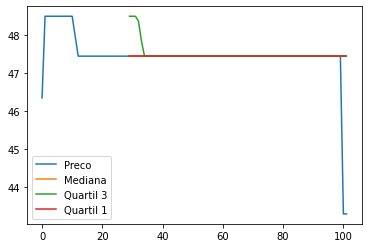

In [ ]:
plt.plot(df["preco"],label='Preco')
plt.plot(moving_median,label="Mediana")
plt.plot(moving_quartile3,label="Quartil 3")
plt.plot(moving_quartile1,label="Quartil 1")
plt.legend()
plt.show()

In [ ]:
# Avaliando Média e Desvio Padrão Móveis (Exponencial)
moving_mean = df.ewm(span=30).mean()
moving_std = df.ewm(30).std()

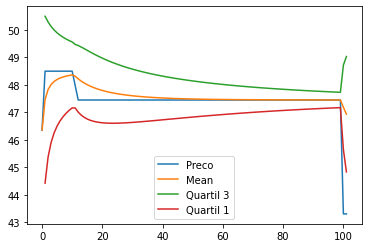

In [ ]:
plt.plot(df["preco"],label='Preco')
plt.plot(moving_mean,label="Mean")
plt.plot(moving_mean+2*moving_std,label="Quartil 3")
plt.plot(moving_mean-2*moving_std,label="Quartil 1")
plt.legend()
plt.show()